In this report, we calculate the portfolio greeks and shock reports for the various ETFs in the holdings file.  As discussed in a previous report, we will be using Black-Scholes-Merton (BSM) implied volatilities as well as the BSM greeks formulas.  It would be interesting to repeat the exercise using a binomial model, and compare the results.

## Importing Packages

Let's start by importing the core packages **numpy** and **pandas**.  We'll also import the **seaborn** visualization package and set some styling.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

## Reading-In Holdings File

Next, we read in the hodlings file that we cleaned in a prior notebook.

In [ ]:
df_holdings = pd.read_csv("../data/etf_holdings_clean_20240802.csv")
df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding
0,2024-08-02,APRT,SPY,2025-03-31,3.87,C,535.0100,1222.00,65378222.00,99.31%,1825000
1,2024-08-02,APRT,SPY,2025-03-31,617.33,C,4.9200,-1222.00,-601224.00,-0.91%,1825000
2,2024-08-02,APRT,SPY,2025-03-31,470.76,P,7.8600,-1222.00,-960492.00,-1.46%,1825000
3,2024-08-02,APRT,SPY,2025-03-31,523.02,P,16.3500,1222.00,1997970.00,3.03%,1825000
4,2024-08-02,APRT,Cash&Other,NaN,NaN,NaN,1.0000,18252.00,18252.00,0.03%,1825000
...,...,...,...,...,...,...,...,...,...,...,...
173,2024-08-02,SIXZ,SPY,2024-10-31,3.71,C,536.4197,150.00,8046295.50,102.81%,300000
174,2024-08-02,SIXZ,SPY,2024-10-31,543.69,C,18.7028,-150.00,-280542.00,-3.58%,300000
175,2024-08-02,SIXZ,SPY,2024-10-31,451.78,P,2.0143,-150.00,-30214.50,-0.39%,300000
176,2024-08-02,SIXZ,SPY,2024-10-31,501.93,P,5.4137,150.00,81205.50,1.04%,300000


## `D2X`, `UPX`, `Moneyness`, `RF`, `DIV`

At this point we can add a variety of columns, mostly from the data files that were provided for the assignment.  Notice that we use simple linear interpolation from **numpy** for the various curves.  In a more high stakes environment I might fit a parametric curve to the data to avoid overfitting.

In [ ]:
# adding D2X
from bizdays import Calendar
cal = Calendar.load("PMC/NYSE")

def bizdays(row):
    from_date = row["Date"]
    to_date = row["MaturityDate"]
    return cal.bizdays(from_date, to_date)

df_holdings["D2X"] = df_holdings.apply(bizdays, axis=1)

# adding UPX
df_spy = pd.read_csv("../data/spy_20240802.csv")
df_spy.dropna(inplace=True)
df_holdings["UPX"] = df_spy.query("date == '8/2/2024'").reset_index()['spy'][0]

# adding Moneyness
df_holdings["Moneyness"] = df_holdings["StrikePrice"] / df_holdings["UPX"]

# adding RF
df_risk_free = pd.read_csv("../data/rates_20240802.csv")

def risk_free(row):
    d2x = row["D2X"]
    # using simple linear interpolation
    return np.interp(d2x, df_risk_free["D2X"], df_risk_free["Close"])

df_holdings["RF"] = df_holdings.apply(risk_free, axis=1) / 100

# adding DIV
df_dividend = pd.read_csv("../data/spx_dividend_20240802.csv")
df_dividend["Date"] = pd.to_datetime("2024-08-02")
df_dividend["DivExpirationDate"] = pd.to_datetime(df_dividend["DivExpirationDate"], format="mixed", dayfirst=True)

def bizdays(row):
    from_date = row["Date"]
    to_date = row["DivExpirationDate"]
    return cal.bizdays(from_date, to_date)

df_dividend["D2X"] = df_dividend.apply(bizdays, axis=1)

def dividend(row):
    d2x = row["D2X"]
    # using simple linear interpolation
    dividend = np.interp(d2x, df_dividend["D2X"], df_dividend["DivCurve"])
    # I wasn't sure how to handle negative dividend yields would affect, so I set them to zero 
    if dividend < 0:
        dividend = 0
    return dividend

df_holdings["Div"] = df_holdings.apply(dividend, axis=1)

# printing holdings dataframe
df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div
0,2024-08-02,APRT,SPY,2025-03-31,3.87,C,535.0100,1222.00,65378222.00,99.31%,1825000,165.0,532.9,0.007262,0.045593,0.00713
1,2024-08-02,APRT,SPY,2025-03-31,617.33,C,4.9200,-1222.00,-601224.00,-0.91%,1825000,165.0,532.9,1.158435,0.045593,0.00713
2,2024-08-02,APRT,SPY,2025-03-31,470.76,P,7.8600,-1222.00,-960492.00,-1.46%,1825000,165.0,532.9,0.883393,0.045593,0.00713
3,2024-08-02,APRT,SPY,2025-03-31,523.02,P,16.3500,1222.00,1997970.00,3.03%,1825000,165.0,532.9,0.981460,0.045593,0.00713
4,2024-08-02,APRT,Cash&Other,NaN,NaN,NaN,1.0000,18252.00,18252.00,0.03%,1825000,NaN,532.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2024-08-02,SIXZ,SPY,2024-10-31,3.71,C,536.4197,150.00,8046295.50,102.81%,300000,63.0,532.9,0.006962,0.051127,0.00843
174,2024-08-02,SIXZ,SPY,2024-10-31,543.69,C,18.7028,-150.00,-280542.00,-3.58%,300000,63.0,532.9,1.020248,0.051127,0.00843
175,2024-08-02,SIXZ,SPY,2024-10-31,451.78,P,2.0143,-150.00,-30214.50,-0.39%,300000,63.0,532.9,0.847776,0.051127,0.00843
176,2024-08-02,SIXZ,SPY,2024-10-31,501.93,P,5.4137,150.00,81205.50,1.04%,300000,63.0,532.9,0.941884,0.051127,0.00843


## `VolatilityImplied` Implied from Prices

Let's now calculate implied volatilities based on the market option prices.  In order to do this we use the **py_vollib** package which is great for Black-Scholes-Merton pricing calculations. We first have to convert the `implied_volatility()` function into a form that can be used in the **pandas** `DataFrame.apply()` method.

Note: for the deep ITM calls, the `implied_volatility()` function was throwing an error.  I think this is because there are tax/regulatory reasons why deep ITM calls can have prices that deviate from theoretically sound values.  Thus, for `Moneyness < 0.1`, I simply set the implied volatility equal to `0.25`.

In [ ]:
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility

def implied_vol(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    price = row["Price"]
    q = row["Div"]

    # getting errors for deep ITM calls, so set those to a fixed value
    if strike / upx < 0.1:
        vol = 0.25
    else:
        vol = implied_volatility(price, upx, strike, t2x, rf, q, cp)
    vol = np.round(vol, 4)
    return vol

df_holdings["VolatilityImplied"] = df_holdings.apply(implied_vol, axis=1)

df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div,VolatilityImplied
0,2024-08-02,APRT,SPY,2025-03-31,3.87,C,535.0100,1222.00,65378222.00,99.31%,1825000,165.0,532.9,0.007262,0.045593,0.00713,0.2500
1,2024-08-02,APRT,SPY,2025-03-31,617.33,C,4.9200,-1222.00,-601224.00,-0.91%,1825000,165.0,532.9,1.158435,0.045593,0.00713,0.1432
2,2024-08-02,APRT,SPY,2025-03-31,470.76,P,7.8600,-1222.00,-960492.00,-1.46%,1825000,165.0,532.9,0.883393,0.045593,0.00713,0.2018
3,2024-08-02,APRT,SPY,2025-03-31,523.02,P,16.3500,1222.00,1997970.00,3.03%,1825000,165.0,532.9,0.981460,0.045593,0.00713,0.1564
4,2024-08-02,APRT,Cash&Other,NaN,NaN,NaN,1.0000,18252.00,18252.00,0.03%,1825000,NaN,532.9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2024-08-02,SIXZ,SPY,2024-10-31,3.71,C,536.4197,150.00,8046295.50,102.81%,300000,63.0,532.9,0.006962,0.051127,0.00843,0.2500
174,2024-08-02,SIXZ,SPY,2024-10-31,543.69,C,18.7028,-150.00,-280542.00,-3.58%,300000,63.0,532.9,1.020248,0.051127,0.00843,0.1982
175,2024-08-02,SIXZ,SPY,2024-10-31,451.78,P,2.0143,-150.00,-30214.50,-0.39%,300000,63.0,532.9,0.847776,0.051127,0.00843,0.2448
176,2024-08-02,SIXZ,SPY,2024-10-31,501.93,P,5.4137,150.00,81205.50,1.04%,300000,63.0,532.9,0.941884,0.051127,0.00843,0.1760


## `Delta`, `Vega`, `Theta`

Next, let's calculate the greeks of the individual options in `df_holdings` using the **py_vollib** package.  Notice that all the functions need to be converted into a form that can be used in the `DataFrame.apply()` method.

In [ ]:
# Delta
from py_vollib.black_scholes_merton.greeks.analytical import delta
def bsm_delta(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row["VolatilityImplied"]
    q = row["Div"]
    
    if t2x == 0:
        return(0)
    diff = delta(cp, upx, strike, t2x, rf, volatility, q)
    diff = np.round(diff, 3)
    return(diff)

df_holdings['Delta'] = df_holdings.apply(bsm_delta, axis=1)  * np.sign(df_holdings['Shares'])

# Vega
from py_vollib.black_scholes_merton.greeks.analytical import vega

def bsm_vega(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row["VolatilityImplied"]
    q = row["Div"]

    if t2x == 0:
        return(0)
    vga = vega(cp, upx, strike, t2x, rf, volatility, q)
    vga = np.round(vga, 3)
    return(vga)

df_holdings['Vega'] = df_holdings.apply(bsm_vega, axis=1) * np.sign(df_holdings['Shares'])

# Theta
from py_vollib.black_scholes_merton.greeks.analytical import theta

def bsm_theta(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row["VolatilityImplied"]
    q = row["Div"]
    
    if t2x == 0:
        return(0)
    tht = theta(cp, upx, strike, t2x, rf, volatility, q) * (365/252)
    tht = np.round(tht, 3)
    return(tht)

df_holdings['Theta'] = df_holdings.apply(bsm_theta, axis=1) * np.sign(df_holdings['Shares'])

# Gamma
from py_vollib.black_scholes_merton.greeks.analytical import gamma

def bsm_gamma(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row["VolatilityImplied"]
    q = row["Div"]
    
    if t2x == 0:
        return(0)
    gma = gamma(cp, upx, strike, t2x, rf, volatility, q) * (365/252)
    gma = np.round(gma, 3)
    return(gma)

df_holdings["Gamma"] = df_holdings.apply(bsm_gamma, axis=1) * np.sign(df_holdings['Shares'])

# printing df_holdings with greeks
df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,...,D2X,UPX,Moneyness,RF,Div,VolatilityImplied,Delta,Vega,Theta,Gamma
0,2024-08-02,APRT,SPY,2025-03-31,3.87,C,535.0100,1222.00,65378222.00,99.31%,...,165.0,532.9,0.007262,0.045593,0.00713,0.2500,0.995,0.000,0.014,0.000
1,2024-08-02,APRT,SPY,2025-03-31,617.33,C,4.9200,-1222.00,-601224.00,-0.91%,...,165.0,532.9,1.158435,0.045593,0.00713,0.1432,-0.159,-1.045,0.057,-0.006
2,2024-08-02,APRT,SPY,2025-03-31,470.76,P,7.8600,-1222.00,-960492.00,-1.46%,...,165.0,532.9,0.883393,0.045593,0.00713,0.2018,0.159,-1.044,0.049,-0.004
3,2024-08-02,APRT,SPY,2025-03-31,523.02,P,16.3500,1222.00,1997970.00,3.03%,...,165.0,532.9,0.981460,0.045593,0.00713,0.1564,-0.339,1.574,-0.044,0.008
4,2024-08-02,APRT,Cash&Other,NaN,NaN,NaN,1.0000,18252.00,18252.00,0.03%,...,NaN,532.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2024-08-02,SIXZ,SPY,2024-10-31,3.71,C,536.4197,150.00,8046295.50,102.81%,...,63.0,532.9,0.006962,0.051127,0.00843,0.2500,0.998,0.000,0.017,0.000
174,2024-08-02,SIXZ,SPY,2024-10-31,543.69,C,18.7028,-150.00,-280542.00,-3.58%,...,63.0,532.9,1.020248,0.051127,0.00843,0.1982,-0.481,-1.060,0.206,-0.011
175,2024-08-02,SIXZ,SPY,2024-10-31,451.78,P,2.0143,-150.00,-30214.50,-0.39%,...,63.0,532.9,0.847776,0.051127,0.00843,0.2448,0.067,-0.346,0.061,-0.003
176,2024-08-02,SIXZ,SPY,2024-10-31,501.93,P,5.4137,150.00,81205.50,1.04%,...,63.0,532.9,0.941884,0.051127,0.00843,0.1760,-0.198,0.742,-0.085,0.009


## Portfolio Greeks & Statistics

Now, we can do a simple `DataFrame.groupby()` to calculate portfolio greeks and other portfolio metrics.

In [ ]:
agg_funcs = {
    'Delta':[np.sum],
    'Vega':[np.sum],
    'Theta':[np.sum],
    'Gamma':[np.sum],
    'D2X':[np.mean],
    'MarketValue':[np.sum],
    'SharesOutstanding':[np.mean],
    'UPX': [np.mean],
}
df_portfolio_statistics = df_holdings.groupby(by=['Account']).agg(agg_funcs).reset_index()
df_portfolio_statistics.columns = df_portfolio_statistics.columns.get_level_values(0)
df_portfolio_statistics['SharePrice'] = np.round(df_portfolio_statistics['MarketValue'] / df_portfolio_statistics['SharesOutstanding'], 2)
df_portfolio_statistics

,Account,Delta,Vega,Theta,Gamma,D2X,MarketValue,SharesOutstanding,UPX,SharePrice
0,APRT,0.656,-0.515,0.076,-0.002,165.0,6.583273e+07,1825000.0,532.9,36.07
1,APRW,0.449,-0.502,0.100,-0.001,165.0,1.939698e+08,6229000.0,532.9,31.14
2,ARLU,0.679,0.876,0.022,0.006,165.0,2.309261e+07,900000.0,532.9,25.66
3,AUGT,0.607,-0.871,0.082,-0.002,249.0,1.672696e+08,5725000.0,532.9,29.22
4,AUGU,0.601,0.719,0.044,0.005,249.0,4.946291e+06,200000.0,532.9,24.73
5,AUGW,0.396,-0.687,0.100,-0.001,249.0,2.775198e+08,9950000.0,532.9,27.89
6,DECT,0.414,-0.987,0.195,-0.007,83.0,2.017996e+07,650000.0,532.9,31.05
7,DECW,0.265,-0.769,0.205,-0.005,83.0,7.960266e+07,2675000.0,532.9,29.76
8,FEBT,0.505,-1.048,0.131,-0.006,125.0,2.708734e+07,850000.0,532.9,31.87
9,FEBW,0.318,-0.848,0.148,-0.004,125.0,7.349425e+07,2475000.0,532.9,29.69


## Trade Recommendations

We now make trade recommendations based on the views that we discussed:

**Delta-Gamma:** "...bullish tilt here with stocks in correction and portfolios outperforming benchmarks on the downside (on relative basis)"

**Vega-Theta:** "...short vol or theta carry perpsective"

We do this by a simple ranking by each of the greeks.  We then combine the greek rankings by a simple sum.  This leads to two rankings that we will use below: `DeltaGammaRanking` and `VegaThetaRanking`.

In [ ]:
df_portfolio_statistics["DeltaRank"] = df_portfolio_statistics["Delta"].rank(ascending=False)
df_portfolio_statistics["VegaRank"] = df_portfolio_statistics["Vega"].rank(ascending=True)
df_portfolio_statistics["ThetaRank"] = df_portfolio_statistics["Theta"].rank(ascending=False)
df_portfolio_statistics["GammaRank"] = df_portfolio_statistics["Gamma"].rank(ascending=False)
df_portfolio_statistics["DeltaGammaRank"] = \
    df_portfolio_statistics["Delta"].rank(ascending=False) + \
    df_portfolio_statistics["Gamma"].rank(ascending=False)
df_portfolio_statistics["VegaThetaRank"] = \
    df_portfolio_statistics["Vega"].rank(ascending=True) + \
    df_portfolio_statistics["Theta"].rank(ascending=False)

df_portfolio_statistics

,Account,Delta,Vega,Theta,Gamma,D2X,MarketValue,SharesOutstanding,UPX,SharePrice,DeltaRank,VegaRank,ThetaRank,GammaRank,DeltaGammaRank,VegaThetaRank
0,APRT,0.656,-0.515,0.076,-0.002,165.0,6.583273e+07,1825000.0,532.9,36.07,4.0,26.0,29.0,14.0,18.0,55.0
1,APRW,0.449,-0.502,0.100,-0.001,165.0,1.939698e+08,6229000.0,532.9,31.14,21.0,27.0,23.5,10.0,31.0,50.5
2,ARLU,0.679,0.876,0.022,0.006,165.0,2.309261e+07,900000.0,532.9,25.66,3.0,36.0,36.0,1.5,4.5,72.0
3,AUGT,0.607,-0.871,0.082,-0.002,249.0,1.672696e+08,5725000.0,532.9,29.22,9.0,7.0,28.0,14.0,23.0,35.0
4,AUGU,0.601,0.719,0.044,0.005,249.0,4.946291e+06,200000.0,532.9,24.73,10.0,33.0,32.0,5.0,15.0,65.0
5,AUGW,0.396,-0.687,0.100,-0.001,249.0,2.775198e+08,9950000.0,532.9,27.89,27.0,16.0,23.5,10.0,37.0,39.5
6,DECT,0.414,-0.987,0.195,-0.007,83.0,2.017996e+07,650000.0,532.9,31.05,24.0,4.0,10.0,34.5,58.5,14.0
7,DECW,0.265,-0.769,0.205,-0.005,83.0,7.960266e+07,2675000.0,532.9,29.76,34.0,11.0,8.0,27.5,61.5,19.0
8,FEBT,0.505,-1.048,0.131,-0.006,125.0,2.708734e+07,850000.0,532.9,31.87,15.0,2.0,17.5,30.5,45.5,19.5
9,FEBW,0.318,-0.848,0.148,-0.004,125.0,7.349425e+07,2475000.0,532.9,29.69,30.0,8.0,14.0,24.5,54.5,22.0


### Delta-Gamma

Let's begin by selecting two *bullish* ETFs with the `DeltaGammaRanking`.

In [ ]:
df_portfolio_statistics.sort_values(["DeltaGammaRank"]).head(10)

,Account,Delta,Vega,Theta,Gamma,D2X,MarketValue,SharesOutstanding,UPX,SharePrice,DeltaRank,VegaRank,ThetaRank,GammaRank,DeltaGammaRank,VegaThetaRank
2,ARLU,0.679,0.876,0.022,0.006,165.0,2.309261e+07,900000.0,532.9,25.66,3.0,36.0,36.0,1.5,4.5,72.0
23,MAYU,0.774,0.868,0.008,0.005,186.0,1.396673e+07,525000.0,532.9,26.60,1.0,35.0,37.0,3.5,4.5,72.0
14,JNEU,0.688,0.896,0.024,0.005,207.0,1.344532e+07,525000.0,532.9,25.61,2.0,37.0,35.0,3.5,5.5,72.0
16,JULU,0.631,0.785,0.039,0.006,227.0,2.998390e+07,1200000.0,532.9,24.99,6.0,34.0,33.0,1.5,7.5,67.0
4,AUGU,0.601,0.719,0.044,0.005,249.0,4.946291e+06,200000.0,532.9,24.73,10.0,33.0,32.0,5.0,15.0,65.0
0,APRT,0.656,-0.515,0.076,-0.002,165.0,6.583273e+07,1825000.0,532.9,36.07,4.0,26.0,29.0,14.0,18.0,55.0
34,SIXO,0.518,-0.180,0.146,0.001,40.0,9.812036e+07,3225000.0,532.9,30.42,14.0,30.0,15.0,6.0,20.0,45.0
15,JULT,0.630,-0.695,0.075,-0.002,227.0,1.137164e+08,3075000.0,532.9,36.98,7.0,15.0,30.0,14.0,21.0,45.0
10,FLAO,0.652,-0.106,0.064,-0.003,40.0,2.063637e+07,800000.0,532.9,25.80,5.0,31.0,31.0,17.5,22.5,62.0
3,AUGT,0.607,-0.871,0.082,-0.002,249.0,1.672696e+08,5725000.0,532.9,29.22,9.0,7.0,28.0,14.0,23.0,35.0


**Recommendations: APRT & JULT**

Both of these names have a high delta (APRT: 0.656, JULT: 0.630), while at the same time having significantly negative vega (APRT: -0.515, JULT: -0.695), which is consistent with your bearish view on implied vols.  Unfortunately, both have negative gamma (APRT: -0.002, JULT: -0.002), but of relatively small magnitude. It seems like it is hard to get positive gamma without incurring significant positive vega.

### Vega-Theta

Next, let's choose our short-vol, theta-carry ETFs by using the `VegaThetaRanking`.

In [ ]:
df_portfolio_statistics.sort_values(["VegaThetaRank"]).head(10)

,Account,Delta,Vega,Theta,Gamma,D2X,MarketValue,SharesOutstanding,UPX,SharePrice,DeltaRank,VegaRank,ThetaRank,GammaRank,DeltaGammaRank,VegaThetaRank
6,DECT,0.414,-0.987,0.195,-0.007,83.0,2.017996e+07,650000.0,532.9,31.05,24.0,4.0,10.0,34.5,58.5,14.0
25,NVBT,0.260,-0.801,0.260,-0.006,63.0,1.015101e+07,325000.0,532.9,31.23,35.0,9.0,6.5,32.5,67.5,15.5
12,JANT,0.482,-1.002,0.151,-0.006,104.0,4.933466e+07,1450000.0,532.9,34.02,18.0,3.0,13.0,30.5,48.5,16.0
7,DECW,0.265,-0.769,0.205,-0.005,83.0,7.960266e+07,2675000.0,532.9,29.76,34.0,11.0,8.0,27.5,61.5,19.0
8,FEBT,0.505,-1.048,0.131,-0.006,125.0,2.708734e+07,850000.0,532.9,31.87,15.0,2.0,17.5,30.5,45.5,19.5
27,OCTT,0.298,-0.685,0.328,-0.008,40.0,3.968637e+07,1075000.0,532.9,36.92,32.0,17.0,4.0,36.0,68.0,21.0
13,JANW,0.305,-0.801,0.165,-0.004,104.0,2.186485e+08,6775000.0,532.9,32.27,31.0,10.0,11.0,24.5,55.5,21.0
9,FEBW,0.318,-0.848,0.148,-0.004,125.0,7.349425e+07,2475000.0,532.9,29.69,30.0,8.0,14.0,24.5,54.5,22.0
22,MAYT,0.554,-1.113,0.101,-0.004,186.0,1.721762e+07,550000.0,532.9,31.30,12.0,1.0,22.0,24.5,36.5,23.0
24,MAYW,0.370,-0.917,0.116,-0.003,186.0,5.623296e+07,1925000.0,532.9,29.21,29.0,5.0,19.0,20.5,49.5,24.0


**Recommendations: MAYT & FEBT**

Both these names have a high negative vega (MAYT: -1.113, FEBT: -1.048), which is consistent with your bearish view on implied vols, and also some positive theta carry (MAYT: 0.10, FEBT: 0.13).  At the same time, both have a relatively high delta (MAYT: 0.554, FEBT: 0.505).  However, this comes at the cost of negative gamma for both names (MAYT: -0.004, FEBT: -0.006).

## Shock-Reports

Now we generate shock-reports for our ETF recommendations.  A shock report is the value of a portfolio for various underlying shocks and parallel volatility shocks.  I assume vols remain constant as the underlying changes, which is a naive assumption.  In a more high-stakes situation I would assume some kind of relationship between changes in vol and changes in the underlying.

Let's begin by creating the functions that generate the shock report for a given ETF.

In [ ]:
# pricing functions
from py_vollib.black_scholes_merton import black_scholes_merton

def bsm_px(row, vol_column):
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)
    
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row[vol_column]
    q = row["Div"]
    px = black_scholes_merton(cp, upx, strike, t2x, rf, volatility, q)
    px = np.round(px, 4)
    
    return(px)

In [ ]:
def generate_shock_report(account, underlying_shocks, vol_shocks):
    df_etf = df_holdings.query("Account == @account")
    df_shock_report = pd.DataFrame()
    for vs in vol_shocks:
        for us in underlying_shocks:
            # applying the shocks to UPX and VolatilityImplied
            df_etf_shocked = df_etf.copy()
            df_etf_shocked["VolatilityImplied"] += vs
            df_etf_shocked["UPX"] = df_etf_shocked["UPX"] * (1 + us)

            # calculating prices for shocked inputs, and then the market values for each
            df_etf_shocked["ShockedPrice"] = df_etf_shocked.apply(bsm_px, vol_column="VolatilityImplied", axis=1)
            df_etf_shocked["ShockedMarketValue"] = df_etf_shocked["Shares"] * df_etf_shocked["ShockedPrice"] * 100

            # using a groupby to calculate ShockedMarketVlaue
            agg_funcs = {
                "ShockedMarketValue":[np.sum],
                "SharesOutstanding":[np.mean],
                "UPX": [np.mean],
            }
            df_portfolio_statistics = df_etf_shocked.groupby(by=['Account']).agg(agg_funcs).reset_index()
            df_portfolio_statistics.columns = df_portfolio_statistics.columns.get_level_values(0)
            
            # calculating share price with shocked market values
            df_portfolio_statistics["SharePrice"] = np.round(df_portfolio_statistics["ShockedMarketValue"] / df_portfolio_statistics["SharesOutstanding"], 2)
            df_portfolio_statistics["ShockVol"] = vs
            df_portfolio_statistics["ShockUnderlying"] = us

            # concatenating 
            df_shock_report = pd.concat([df_shock_report, df_portfolio_statistics])
            
    return(df_shock_report)

We are now ready to generate shock reports for any of the ETFs.  In the subsections below we generate them for AUGW and APRT. The vertical line in the graphs is the spot SPY price, 559.99.

### APRT

In [ ]:
df_holdings.query("Account=='APRT'")

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,...,D2X,UPX,Moneyness,RF,Div,VolatilityImplied,Delta,Vega,Theta,Gamma
0,2024-08-02,APRT,SPY,2025-03-31,3.87,C,535.01,1222.0,65378222.0,99.31%,...,165.0,532.9,0.007262,0.045593,0.00713,0.2500,0.995,0.000,0.014,0.000
1,2024-08-02,APRT,SPY,2025-03-31,617.33,C,4.92,-1222.0,-601224.0,-0.91%,...,165.0,532.9,1.158435,0.045593,0.00713,0.1432,-0.159,-1.045,0.057,-0.006
2,2024-08-02,APRT,SPY,2025-03-31,470.76,P,7.86,-1222.0,-960492.0,-1.46%,...,165.0,532.9,0.883393,0.045593,0.00713,0.2018,0.159,-1.044,0.049,-0.004
3,2024-08-02,APRT,SPY,2025-03-31,523.02,P,16.35,1222.0,1997970.0,3.03%,...,165.0,532.9,0.981460,0.045593,0.00713,0.1564,-0.339,1.574,-0.044,0.008
4,2024-08-02,APRT,Cash&Other,NaN,NaN,NaN,1.00,18252.0,18252.0,0.03%,...,NaN,532.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


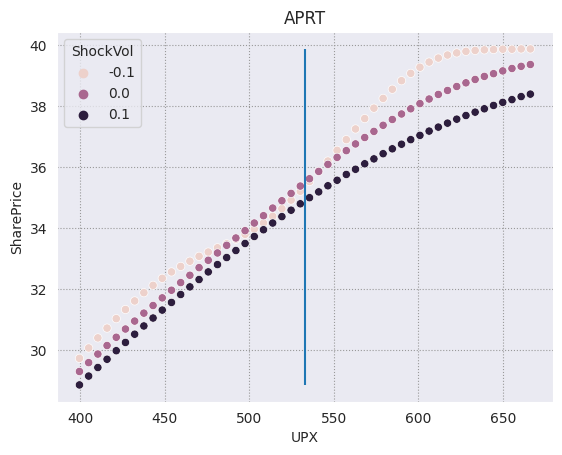

In [ ]:
vol_shocks = [-0.10, 0, 0.10]
underlying_shocks = np.linspace(-0.25, 0.25, 50)
df_shock_report = generate_shock_report(account="APRT", underlying_shocks=underlying_shocks, vol_shocks=vol_shocks)
ax = sns.scatterplot(data=df_shock_report, x="UPX", y="SharePrice", hue="ShockVol");
ax.vlines(x=532.9, ymin=df_shock_report["SharePrice"].min(), ymax=df_shock_report["SharePrice"].max());
ax.set_title("APRT");

### JULT

In [ ]:
df_holdings.query("Account=='JULT'")

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,...,D2X,UPX,Moneyness,RF,Div,VolatilityImplied,Delta,Vega,Theta,Gamma
70,2024-08-02,JULT,SPY,2025-06-30,4.03,C,532.9092,2104.00,1.121241e+08,98.60%,...,227.0,532.9,0.007562,0.043032,0.0066,0.2500,0.994,0.000,0.013,0.000
71,2024-08-02,JULT,SPY,2025-06-30,635.98,C,5.1294,-2104.00,-1.079226e+06,-0.95%,...,227.0,532.9,1.193432,0.043032,0.0066,0.1381,-0.150,-1.176,0.046,-0.005
72,2024-08-02,JULT,SPY,2025-06-30,489.80,P,12.9300,-2104.00,-2.720472e+06,-2.39%,...,227.0,532.9,0.919122,0.043032,0.0066,0.1831,0.222,-1.501,0.041,-0.005
73,2024-08-02,JULT,SPY,2025-06-30,544.17,P,25.6684,2104.00,5.400631e+06,4.75%,...,227.0,532.9,1.021148,0.043032,0.0066,0.1440,-0.436,1.982,-0.025,0.008
74,2024-08-02,JULT,Cash&Other,NaN,NaN,NaN,1.0000,-8627.64,-8.627640e+03,-0.01%,...,NaN,532.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


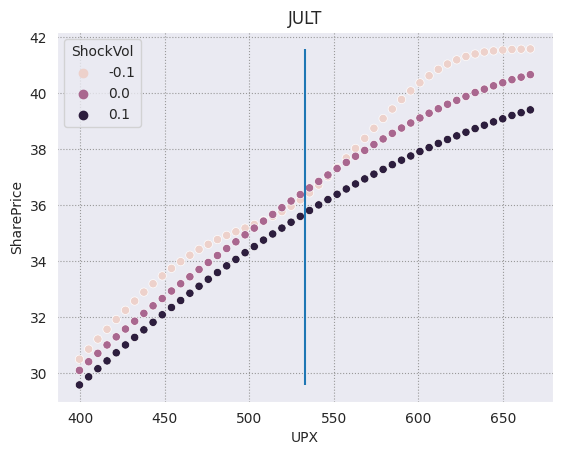

In [ ]:
vol_shocks = [-0.10, 0, 0.10]
underlying_shocks = np.linspace(-0.25, 0.25, 50)
df_shock_report = generate_shock_report(account="JULT", underlying_shocks=underlying_shocks, vol_shocks=vol_shocks)
ax = sns.scatterplot(data=df_shock_report, x="UPX", y="SharePrice", hue="ShockVol");
ax.vlines(x=532.9, ymin=df_shock_report["SharePrice"].min(), ymax=df_shock_report["SharePrice"].max());
ax.set_title("JULT");

### MAYT

In [ ]:
df_holdings.query("Account=='MAYT'")

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,...,D2X,UPX,Moneyness,RF,Div,VolatilityImplied,Delta,Vega,Theta,Gamma
104,2024-08-02,MAYT,SPY,2025-04-30,3.71,C,534.6045,327.00,17481567.15,101.53%,...,186.0,532.9,0.006962,0.044645,0.006564,0.2500,0.995,0.000,0.013,0.000
105,2024-08-02,MAYT,SPY,2025-04-30,589.78,C,13.6848,-327.00,-447492.96,-2.60%,...,186.0,532.9,1.106737,0.044645,0.006564,0.1570,-0.315,-1.623,0.091,-0.007
106,2024-08-02,MAYT,SPY,2025-04-30,451.78,P,6.7450,-327.00,-220561.50,-1.28%,...,186.0,532.9,0.847776,0.044645,0.006564,0.2148,0.127,-0.950,0.043,-0.003
107,2024-08-02,MAYT,SPY,2025-04-30,501.93,P,13.0799,327.00,427712.73,2.48%,...,186.0,532.9,0.941884,0.044645,0.006564,0.1744,-0.253,1.460,-0.046,0.006
108,2024-08-02,MAYT,Cash&Other,NaN,NaN,NaN,1.0000,-23609.35,-23609.35,-0.14%,...,NaN,532.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


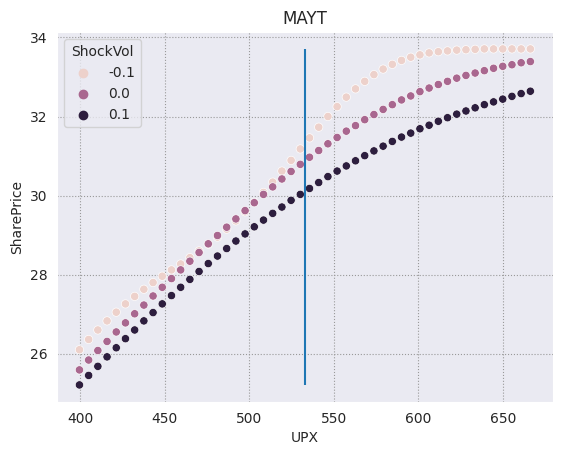

In [ ]:
vol_shocks = [-0.10, 0, 0.10]
underlying_shocks = np.linspace(-0.25, 0.25, 50)
df_shock_report = generate_shock_report(account="MAYT", underlying_shocks=underlying_shocks, vol_shocks=vol_shocks)
ax = sns.scatterplot(data=df_shock_report, x="UPX", y="SharePrice", hue="ShockVol");
ax.vlines(x=532.9, ymin=df_shock_report["SharePrice"].min(), ymax=df_shock_report["SharePrice"].max());
ax.set_title("MAYT");

### FEBT

In [ ]:
df_holdings.query("Account=='FEBT'")

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,...,D2X,UPX,Moneyness,RF,Div,VolatilityImplied,Delta,Vega,Theta,Gamma
38,2024-08-02,FEBT,SPY,2025-01-31,3.57,C,535.4244,519.00,27788526.36,102.59%,...,125.0,532.9,0.006699,0.047406,0.00568,0.2500,0.997,0.000,0.011,0.000
39,2024-08-02,FEBT,SPY,2025-01-31,564.97,C,17.1747,-519.00,-891366.93,-3.29%,...,125.0,532.9,1.060180,0.047406,0.00568,0.1718,-0.400,-1.447,0.131,-0.009
40,2024-08-02,FEBT,SPY,2025-01-31,434.59,P,3.5990,-519.00,-186788.10,-0.69%,...,125.0,532.9,0.815519,0.047406,0.00568,0.2431,0.081,-0.562,0.047,-0.002
41,2024-08-02,FEBT,SPY,2025-01-31,482.83,P,7.2636,519.00,376980.84,1.39%,...,125.0,532.9,0.906042,0.047406,0.00568,0.1947,-0.173,0.961,-0.058,0.005
42,2024-08-02,FEBT,Cash&Other,NaN,NaN,NaN,1.0000,-12.14,-12.14,0.00%,...,NaN,532.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


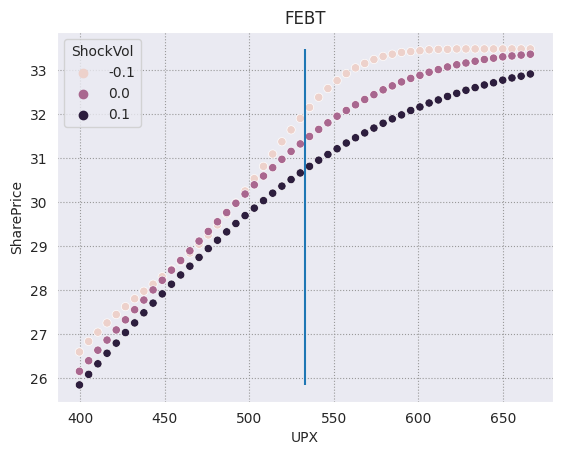

In [ ]:
vol_shocks = [-0.10, 0, 0.10]
underlying_shocks = np.linspace(-0.25, 0.25, 50)
df_shock_report = generate_shock_report(account="FEBT", underlying_shocks=underlying_shocks, vol_shocks=vol_shocks)
ax = sns.scatterplot(data=df_shock_report, x="UPX", y="SharePrice", hue="ShockVol");
ax.vlines(x=532.9, ymin=df_shock_report["SharePrice"].min(), ymax=df_shock_report["SharePrice"].max());
ax.set_title("FEBT");